Please upload your cleaned_hospital_readmission.parquet file...


Saving cleaned_hospital_readmission.parquet to cleaned_hospital_readmission.parquet

=== Tuning LightGBM ===
Tuning LightGBM with SMOTE...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 33859, number of negative: 67719
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1988
[LightGBM] [Info] Number of data points in the train set: 101578, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693162
[LightGBM] [Info] Start training from score -0.693162
[LightGBM] [Warning] No further splits with positive gain, best gain: -

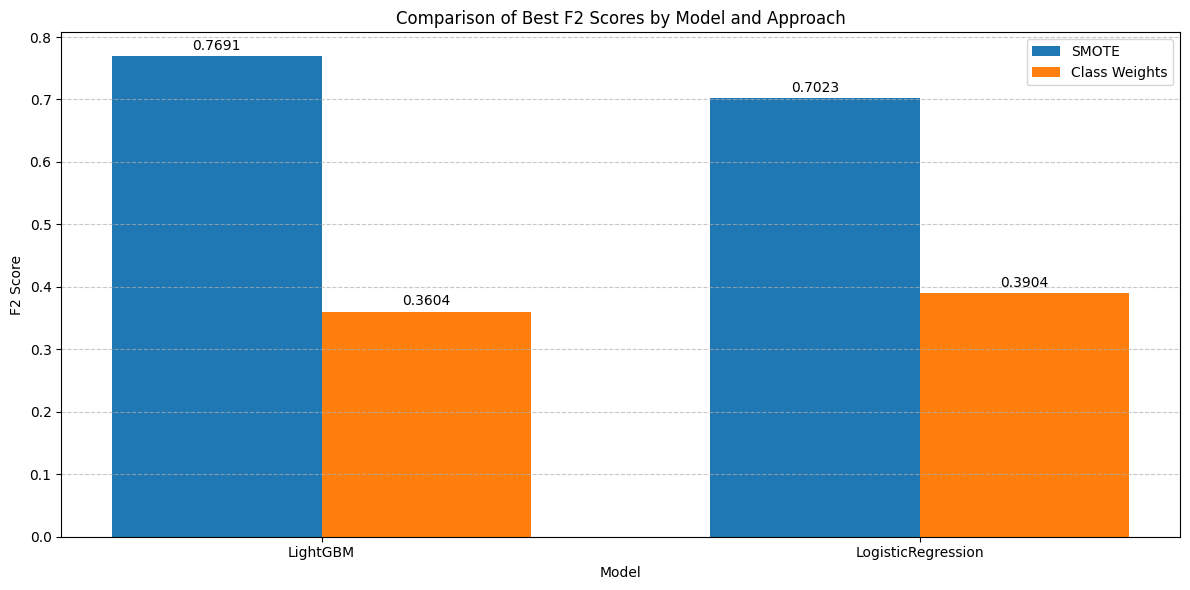

AttributeError: 'DataFrame' object has no attribute 'append'

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTENC
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import time
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

# Function to upload and preprocess data
def load_and_prepare_data():
    # For Colab, you'll need to upload your parquet file
    print("Please upload your cleaned_hospital_readmission.parquet file...")
    uploaded = files.upload()

    # Read the uploaded file
    file_name = list(uploaded.keys())[0]
    df = pd.read_parquet(file_name)

    # Convert categorical columns
    categorical_cols = [col for col in df.columns if df[col].dtype == 'object']
    for col in categorical_cols:
        df[col] = df[col].astype('category')

    # Convert target to binary
    df["readmitted_binary"] = df["readmitted"].apply(lambda x: 1 if x == "<30" else 0)

    # Split data
    X = df.drop(columns=["readmitted", "readmitted_binary"])
    y = df["readmitted_binary"]

    # Apply feature engineering
    X_enriched = feature_engineering(X)

    # Identify categorical features
    cat_columns = X_enriched.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_columns = X_enriched.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Split data into train and validation sets (keep a separate test set untouched)
    X_train, X_val, y_train, y_val = train_test_split(
        X_enriched, y, random_state=1984, stratify=y, test_size=0.2
    )

    return X_train, X_val, y_train, y_val, cat_columns, numerical_columns

# Feature engineering function
def feature_engineering(X):
    med_columns = [
        'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
        'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
        'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
        'miglitol', 'troglitazone', 'tolazamide', 'insulin',
        'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone',
        'metformin-pioglitazone'
    ]

    data = X.copy()

    # Medication features
    data['med_count'] = data[med_columns].apply(lambda x: (x != 'No').sum(), axis=1)
    data['on_multiple_meds'] = (data['med_count'] >= 3).astype(int)
    data['med_changes_total'] = data[med_columns].apply(
        lambda x: ((x == 'Up') | (x == 'Down')).sum(), axis=1)
    data['insulin_binary'] = (data['insulin'] != 'No').astype(int)

    # Hospital utilization features
    data['total_visits'] = data['number_outpatient'] + data['number_emergency'] + data['number_inpatient']
    data['high_utilizer'] = ((data['number_inpatient'] > 1) |
                            (data['number_emergency'] > 2) |
                            (data['number_outpatient'] > 5)).astype(int)

    # Admission features
    data['is_emergency'] = (data['admission_type'] == 'Urgent/Emergency').astype(int)

    return data

# Create SMOTE-balanced version of data
def apply_smote(X_train, y_train, cat_columns):
    cat_indices = [X_train.columns.get_loc(col) for col in cat_columns]
    smote = SMOTENC(sampling_strategy=0.5, random_state=42, categorical_features=cat_indices)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    return X_train_balanced, y_train_balanced

# F2 score for evaluation
def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

# Define scoring metric for CV
f2_scorer = make_scorer(f2_score)

# Function to tune CatBoost with both approaches
def tune_catboost(X_train, X_val, y_train, y_val, cat_columns):
    results = {}

    # Parameter grid for CatBoost
    param_grid = {
        'iterations': [300, 500, 700],
        'learning_rate': [0.01, 0.05, 0.1],
        'depth': [4, 6, 8, 10],
        'l2_leaf_reg': [1, 3, 5, 7],
        'border_count': [32, 64, 128]
    }

    # Prepare validation data once
    val_pool = Pool(data=X_val, label=y_val, cat_features=cat_columns)

    # 1. Tune CatBoost with SMOTE
    print("Tuning CatBoost with SMOTE...")
    X_train_balanced, y_train_balanced = apply_smote(X_train, y_train, cat_columns)
    train_pool_smote = Pool(data=X_train_balanced, label=y_train_balanced, cat_features=cat_columns)

    best_score_smote = -float('inf')
    best_params_smote = None

    # Random search for SMOTE approach
    for _ in range(20):  # Try 20 random combinations
        # Randomly sample parameters
        params = {
            'iterations': np.random.choice(param_grid['iterations']),
            'learning_rate': np.random.choice(param_grid['learning_rate']),
            'depth': np.random.choice(param_grid['depth']),
            'l2_leaf_reg': np.random.choice(param_grid['l2_leaf_reg']),
            'border_count': np.random.choice(param_grid['border_count']),
            'verbose': 0
        }

        # Train model
        model = CatBoostClassifier(**params, random_seed=1984, eval_metric='F1')
        model.fit(train_pool_smote)

        # Evaluate
        y_pred = model.predict(val_pool)
        score = f2_score(y_val, y_pred)

        if score > best_score_smote:
            best_score_smote = score
            best_params_smote = params

    # 2. Tune CatBoost with class weights
    print("Tuning CatBoost with class weights...")
    # Calculate class weight
    neg_count, pos_count = np.bincount(y_train)
    scale_pos_weight = neg_count / pos_count

    train_pool_cw = Pool(data=X_train, label=y_train, cat_features=cat_columns)

    best_score_cw = -float('inf')
    best_params_cw = None

    # Random search for class weights approach
    for _ in range(20):
        # Randomly sample parameters
        params = {
            'iterations': np.random.choice(param_grid['iterations']),
            'learning_rate': np.random.choice(param_grid['learning_rate']),
            'depth': np.random.choice(param_grid['depth']),
            'l2_leaf_reg': np.random.choice(param_grid['l2_leaf_reg']),
            'border_count': np.random.choice(param_grid['border_count']),
            'class_weights': [1, scale_pos_weight],
            'verbose': 0
        }

        # Train model
        model = CatBoostClassifier(**params, random_seed=1984, eval_metric='F1')
        model.fit(train_pool_cw)

        # Evaluate
        y_pred = model.predict(val_pool)
        score = f2_score(y_val, y_pred)

        if score > best_score_cw:
            best_score_cw = score
            best_params_cw = params

    results = {
        'SMOTE': {
            'best_params': best_params_smote,
            'best_score': best_score_smote
        },
        'Class Weights': {
            'best_params': best_params_cw,
            'best_score': best_score_cw
        }
    }

    return results

# Function to tune LightGBM with both approaches
def tune_lightgbm(X_train, X_val, y_train, y_val, cat_columns):
    results = {}

    # Parameter grid for LightGBM
    param_grid = {
        'n_estimators': [100, 300, 500],
        'learning_rate': [0.01, 0.1],
        'max_depth': [4, 6, 8, 10]
    }

    # Get categorical indices
    cat_indices = [X_train.columns.get_loc(col) for col in cat_columns]

    # 1. Tune LightGBM with SMOTE
    print("Tuning LightGBM with SMOTE...")
    X_train_balanced, y_train_balanced = apply_smote(X_train, y_train, cat_columns)
    cat_indices_balanced = [X_train_balanced.columns.get_loc(col) for col in cat_columns]

    # Setup cross-validation
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Create RandomizedSearchCV for SMOTE approach
    lightgbm_smote = LGBMClassifier(objective='binary', random_state=1984)

    random_search_smote = RandomizedSearchCV(
        lightgbm_smote,
        param_distributions=param_grid,
        n_iter=5,
        scoring=f2_scorer,
        cv=cv,
        random_state=42,
        n_jobs=-1
    )

    # Fit with SMOTE-balanced data
    random_search_smote.fit(
        X_train_balanced,
        y_train_balanced,
        categorical_feature=cat_indices_balanced
    )

    # 2. Tune LightGBM with class weights
    print("Tuning LightGBM with class weights...")
    # Calculate class weight
    neg_count, pos_count = np.bincount(y_train)
    scale_pos_weight = neg_count / pos_count

    # Create RandomizedSearchCV for class weights approach
    lightgbm_cw = LGBMClassifier(
        objective='binary',
        random_state=1984,
        scale_pos_weight=scale_pos_weight
    )

    random_search_cw = RandomizedSearchCV(
        lightgbm_cw,
        param_distributions=param_grid,
        n_iter=5,
        scoring=f2_scorer,
        cv=cv,
        random_state=42,
        n_jobs=-1
    )

    # Fit with original data and class weights
    random_search_cw.fit(
        X_train,
        y_train,
        categorical_feature=cat_indices
    )

    results = {
        'SMOTE': {
            'best_params': random_search_smote.best_params_,
            'best_score': random_search_smote.best_score_
        },
        'Class Weights': {
            'best_params': random_search_cw.best_params_,
            'best_score': random_search_cw.best_score_
        }
    }

    return results

# Function to tune XGBoost with both approaches
def tune_xgboost(X_train, X_val, y_train, y_val, cat_columns, numerical_columns):
    results = {}

    # Parameter grid for XGBoost
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 4, 5, 6],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.2],
        'min_child_weight': [1, 3, 5]
    }

    # Preprocessor for XGBoost
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_columns),
            ('num', StandardScaler(), numerical_columns)
        ])

    # 1. Tune XGBoost with SMOTE
    print("Tuning XGBoost with SMOTE...")
    X_train_balanced, y_train_balanced = apply_smote(X_train, y_train, cat_columns)

    # Setup cross-validation
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Create pipeline for SMOTE approach
    xgb_pipeline_smote = Pipeline([
        ('preprocessor', preprocessor),
        ('xgboost', XGBClassifier(random_state=1984))
    ])

    # Parameters for pipeline
    param_grid_pipeline_smote = {
        'xgboost__' + key: value for key, value in param_grid.items()
    }

    # Create RandomizedSearchCV for SMOTE approach
    random_search_smote = RandomizedSearchCV(
        xgb_pipeline_smote,
        param_distributions=param_grid_pipeline_smote,
        n_iter=20,
        scoring=f2_scorer,
        cv=cv,
        random_state=42,
        n_jobs=-1
    )

    # Fit with SMOTE-balanced data
    random_search_smote.fit(X_train_balanced, y_train_balanced)

    # 2. Tune XGBoost with class weights
    print("Tuning XGBoost with class weights...")
    # Calculate class weight
    neg_count, pos_count = np.bincount(y_train)
    scale_pos_weight = neg_count / pos_count

    # Create pipeline for class weights approach
    xgb_pipeline_cw = Pipeline([
        ('preprocessor', preprocessor),
        ('xgboost', XGBClassifier(random_state=1984, scale_pos_weight=scale_pos_weight))
    ])

    # Parameters for pipeline
    param_grid_pipeline_cw = {
        'xgboost__' + key: value for key, value in param_grid.items()
    }

    # Create RandomizedSearchCV for class weights approach
    random_search_cw = RandomizedSearchCV(
        xgb_pipeline_cw,
        param_distributions=param_grid_pipeline_cw,
        n_iter=20,
        scoring=f2_scorer,
        cv=cv,
        random_state=42,
        n_jobs=-1
    )

    # Fit with original data
    random_search_cw.fit(X_train, y_train)

    results = {
        'SMOTE': {
            'best_params': {k.replace('xgboost__', ''): v for k, v in random_search_smote.best_params_.items()},
            'best_score': random_search_smote.best_score_
        },
        'Class Weights': {
            'best_params': {k.replace('xgboost__', ''): v for k, v in random_search_cw.best_params_.items()},
            'best_score': random_search_cw.best_score_
        }
    }

    return results

# Function to tune RandomForest with both approaches
def tune_randomforest(X_train, X_val, y_train, y_val, cat_columns):
    results = {}

    # Parameter grid for RandomForest
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    }

    # Preprocess data - one-hot encode categorical features
    X_train_rf = pd.get_dummies(X_train, columns=cat_columns, drop_first=False)
    X_val_rf = pd.get_dummies(X_val, columns=cat_columns, drop_first=False)

    # Ensure columns match
    train_cols = set(X_train_rf.columns)
    val_cols = set(X_val_rf.columns)

    for col in train_cols - val_cols:
        X_val_rf[col] = 0

    # 1. Tune RandomForest with SMOTE
    print("Tuning RandomForest with SMOTE...")
    X_train_balanced, y_train_balanced = apply_smote(X_train, y_train, cat_columns)
    X_train_balanced_rf = pd.get_dummies(X_train_balanced, columns=cat_columns, drop_first=False)

    # Ensure columns match
    for col in train_cols - set(X_train_balanced_rf.columns):
        X_train_balanced_rf[col] = 0

    # Setup cross-validation
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Create RandomizedSearchCV for SMOTE approach
    rf_smote = RandomForestClassifier(random_state=1984, n_jobs=-1)

    random_search_smote = RandomizedSearchCV(
        rf_smote,
        param_distributions=param_grid,
        n_iter=20,
        scoring=f2_scorer,
        cv=cv,
        random_state=42,
        n_jobs=-1
    )

    # Fit with SMOTE-balanced data
    random_search_smote.fit(X_train_balanced_rf, y_train_balanced)

    # 2. Tune RandomForest with class weights
    print("Tuning RandomForest with class weights...")

    # Create RandomizedSearchCV for class weights approach
    rf_cw = RandomForestClassifier(random_state=1984, class_weight='balanced_subsample', n_jobs=-1)

    random_search_cw = RandomizedSearchCV(
        rf_cw,
        param_distributions=param_grid,
        n_iter=20,
        scoring=f2_scorer,
        cv=cv,
        random_state=42,
        n_jobs=-1
    )

    # Fit with original data
    random_search_cw.fit(X_train_rf, y_train)

    results = {
        'SMOTE': {
            'best_params': random_search_smote.best_params_,
            'best_score': random_search_smote.best_score_
        },
        'Class Weights': {
            'best_params': random_search_cw.best_params_,
            'best_score': random_search_cw.best_score_
        }
    }

    return results

# Function to tune LogisticRegression with both approaches
def tune_logistic_regression(X_train, X_val, y_train, y_val, cat_columns, numerical_columns):
    results = {}

    # Parameter grid for LogisticRegression
    param_grid = {
        'C': [0.001, 0.1, 1, 10],
        'solver': ['liblinear', 'saga'],
        'penalty': ['l1', 'l2']
    }

    # Preprocess data - one-hot encode categorical features and scale numerical
    X_train_lr = pd.get_dummies(X_train, columns=cat_columns, drop_first=False)
    X_val_lr = pd.get_dummies(X_val, columns=cat_columns, drop_first=False)

    # Ensure columns match
    train_cols = set(X_train_lr.columns)
    val_cols = set(X_val_lr.columns)

    for col in train_cols - val_cols:
        X_val_lr[col] = 0

    # Scale numerical features
    scaler = StandardScaler()
    num_cols = [col for col in X_train_lr.columns if col in numerical_columns]
    X_train_lr[num_cols] = scaler.fit_transform(X_train_lr[num_cols])
    X_val_lr[num_cols] = scaler.transform(X_val_lr[num_cols])

    # 1. Tune LogisticRegression with SMOTE
    print("Tuning LogisticRegression with SMOTE...")
    X_train_balanced, y_train_balanced = apply_smote(X_train, y_train, cat_columns)
    X_train_balanced_lr = pd.get_dummies(X_train_balanced, columns=cat_columns, drop_first=False)

    # Ensure columns match
    for col in train_cols - set(X_train_balanced_lr.columns):
        X_train_balanced_lr[col] = 0

    # Scale numerical features for SMOTE data
    X_train_balanced_lr[num_cols] = scaler.transform(X_train_balanced_lr[num_cols])

    # Setup cross-validation
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Create RandomizedSearchCV for SMOTE approach
    lr_smote = LogisticRegression(random_state=1984, max_iter=1000)

    random_search_smote = RandomizedSearchCV(
        lr_smote,
        param_distributions=param_grid,
        n_iter=5,
        scoring=f2_scorer,
        cv=cv,
        random_state=42,
        n_jobs=-1
    )

    # Fit with SMOTE-balanced data
    random_search_smote.fit(X_train_balanced_lr, y_train_balanced)

    # 2. Tune LogisticRegression with class weights
    print("Tuning LogisticRegression with class weights...")

    # Create RandomizedSearchCV for class weights approach
    lr_cw = LogisticRegression(random_state=1984, class_weight='balanced', max_iter=1000)

    random_search_cw = RandomizedSearchCV(
        lr_cw,
        param_distributions=param_grid,
        n_iter=5,
        scoring=f2_scorer,
        cv=cv,
        random_state=42,
        n_jobs=-1
    )

    # Fit with original data
    random_search_cw.fit(X_train_lr, y_train)

    results = {
        'SMOTE': {
            'best_params': random_search_smote.best_params_,
            'best_score': random_search_smote.best_score_
        },
        'Class Weights': {
            'best_params': random_search_cw.best_params_,
            'best_score': random_search_cw.best_score_
        }
    }

    return results

# Main function to run all hyperparameter tuning
def run_hyperparameter_tuning():
    start_time = time.time()

    # Load and prepare data
    X_train, X_val, y_train, y_val, cat_columns, numerical_columns = load_and_prepare_data()

    # Dictionary to store all results
    all_results = {}

    # Tune all models
    #print("\n=== Tuning CatBoost ===")
    #all_results['CatBoost'] = tune_catboost(X_train, X_val, y_train, y_val, cat_columns)

    print("\n=== Tuning LightGBM ===")
    all_results['LightGBM'] = tune_lightgbm(X_train, X_val, y_train, y_val, cat_columns)

    #print("\n=== Tuning XGBoost ===")
    #all_results['XGBoost'] = tune_xgboost(X_train, X_val, y_train, y_val, cat_columns, numerical_columns)

    #print("\n=== Tuning RandomForest ===")
    #all_results['RandomForest'] = tune_randomforest(X_train, X_val, y_train, y_val, cat_columns)

    print("\n=== Tuning LogisticRegression ===")
    all_results['LogisticRegression'] = tune_logistic_regression(X_train, X_val, y_train, y_val, cat_columns, numerical_columns)

    # Print results summary
    print("\n=== RESULTS SUMMARY ===")
    for model_name, results in all_results.items():
        print(f"\n{model_name}:")
        print(f"  SMOTE - Best F2 Score: {results['SMOTE']['best_score']:.4f}")
        print(f"  Class Weights - Best F2 Score: {results['Class Weights']['best_score']:.4f}")

        print(f"\n  SMOTE - Best Parameters:")
        for param, value in results['SMOTE']['best_params'].items():
            print(f"    {param}: {value}")

        print(f"\n  Class Weights - Best Parameters:")
        for param, value in results['Class Weights']['best_params'].items():
            print(f"    {param}: {value}")

    # Create a visual comparison
    model_names = list(all_results.keys())
    smote_scores = [results['SMOTE']['best_score'] for results in all_results.values()]
    cw_scores = [results['Class Weights']['best_score'] for results in all_results.values()]

    plt.figure(figsize=(12, 6))
    width = 0.35
    x = np.arange(len(model_names))

    plt.bar(x - width/2, smote_scores, width, label='SMOTE')
    plt.bar(x + width/2, cw_scores, width, label='Class Weights')

    plt.xlabel('Model')
    plt.ylabel('F2 Score')
    plt.title('Comparison of Best F2 Scores by Model and Approach')
    plt.xticks(x, model_names)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for i, v in enumerate(smote_scores):
        plt.text(i - width/2, v + 0.01, f'{v:.4f}', ha='center')

    for i, v in enumerate(cw_scores):
        plt.text(i + width/2, v + 0.01, f'{v:.4f}', ha='center')

    plt.tight_layout()
    plt.show()

    # Save results to CSV
    results_df = pd.DataFrame({
        'Model': [],
        'Approach': [],
        'F2 Score': [],
        'Parameters': []
    })

    for model_name, results in all_results.items():
        for approach in ['SMOTE', 'Class Weights']:
            results_df = results_df.append({
                'Model': model_name,
                'Approach': approach,
                'F2 Score': results[approach]['best_score'],
                'Parameters': str(results[approach]['best_params'])
            }, ignore_index=True)

    results_df.to_csv('hyperparameter_tuning_results.csv', index=False)
    print("\nResults saved to hyperparameter_tuning_results.csv")

    # Print execution time
    execution_time = time.time() - start_time
    print(f"\nTotal execution time: {execution_time/60:.2f} minutes")

    return all_results

# Run tuning if script is executed
if __name__ == "__main__":
    results = run_hyperparameter_tuning()

In [4]:
results_df

NameError: name 'results_df' is not defined